In [17]:
import h5py
from scipy.io import loadmat
hdr_path = "D:\\HSI Project\\Updated_Work\\HSI_Classification\\Minerals_Dataset\\HDR_Data\\Extracted_Folder\\0110\\A.hdr.h5"
hdr_data = h5py.File(hdr_path,'r')['hdr'][:]
mask_act_path = "D:\\HSI Project\\Updated_Work\\HSI_Classification\\Minerals_Dataset\\Minerals_mat_files\\0110_A_gt.mat"
mask_actual = loadmat(mask_act_path)['MASK']

In [18]:
hdr_data.shape

(256, 320, 410)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
def spatial_avg(data,coordinates,kernel_size=3):
    (x,y,c) = coordinates
    # data = patch[:,:,c].copy()
    while (np.isnan(data[x,y]) and kernel_size<=5):
        max_x = data.shape[0]-1
        max_y = data.shape[1]-1
        start_x = max(0,x-kernel_size//2)
        start_y = max(0,y-kernel_size//2)
        end_x = min(max_x,x+kernel_size//2)+1
        end_y = min(max_y,y+kernel_size//2)+1
        neighbours = []
        for i in range(start_x,end_x):
            for j in range(start_y,end_y):
                neighbours.append(data[i,j])
        # Check if all elements are nan
        all_nan = all(np.isnan(x) for x in neighbours)
        if all_nan:
            kernel_size+=2
            continue
        data[x,y] = np.nanmean(neighbours)
    return data
def fill_nan_hdr(hsi_img):
    # hsi_img: shape (h,w,c)
    hsi = hsi_img.copy()
    ind = np.transpose(np.where(np.isnan(hsi)))
    ind = np.array(sorted(ind,key=lambda x: (x[2],x[0],x[1])))
    for (x,y,c) in tqdm(ind,total=len(ind)):
        if (c==0):
            if not np.isnan(hsi[x,y,c+1]):
                hsi[x,y,c] = hsi[x,y,c+1]
            else:
                hsi[:,:,c] = spatial_avg(hsi[:,:,c],(x,y,c))
        elif (c==255):
            if not np.isnan(hsi[x,y,c-1]):
                hsi[x,y,c] = hsi[x,y,c-1]
            else:
                hsi[:,:,c] = spatial_avg(hsi[:,:,c],(x,y,c))
        else:
            if (not np.isnan(hsi[x,y,c+1])) and (not np.isnan(hsi[x,y,c-1])):
                hsi[x,y,c] = np.mean([hsi[x,y,c+1],hsi[x,y,c-1]])
            elif not np.isnan(hsi[x,y,c-1]):
                hsi[x,y,c] = hsi[x,y,c-1]
            elif not np.isnan(hsi[x,y,c+1]):
                hsi[x,y,c] = hsi[x,y,c+1]
            else:
                hsi[:,:,c] = spatial_avg(hsi[:,:,c],(x,y,c))
    return hsi

new = np.transpose(hdr_data,axes=(1,2,0))
print(new.shape)

hsi = fill_nan_hdr(new)
print(hsi.shape)

(320, 410, 256)


100%|██████████| 513778/513778 [00:01<00:00, 386798.58it/s]

(320, 410, 256)


In [34]:
min(2,3)

2

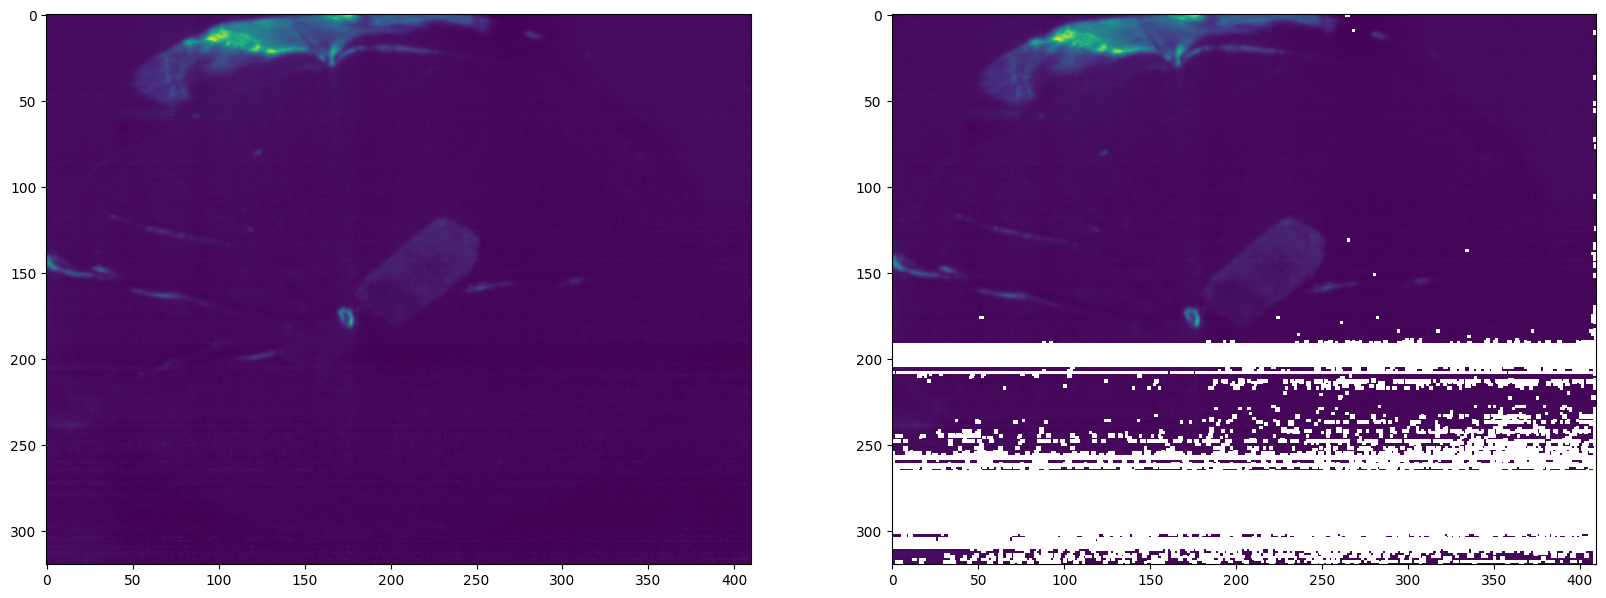

In [23]:
fig,ax = plt.subplots(1,2,figsize=(20,10))
cmap = 'viridis'
ch = 255
ax[0].imshow(hsi[:,:,ch],cmap=cmap)
ax[1].imshow(hdr_data[ch,:,:],cmap=cmap)
plt.show()

In [3]:
import numpy as np
def create_patches(hdr_data_padded,patch_size,row,col,padding):
    # Selecting patch_size x patch_size shape patches from hdr_data
    start_x = patch_size//2
    start_y = patch_size//2
    end_x = row + (patch_size//2)
    end_y = col + (patch_size//2)
    
    patches = []
    positions = []
    for x in range(start_x,end_x):
        for y in range(start_y,end_y):
            patch = np.transpose(hdr_data_padded[:,x-padding:x+padding+1,y-padding:y+padding+1],axes=(1,2,0))
            patches.append(patch)
            positions.append((x-padding,y-padding))
    return patches,positions

In [4]:
patch_size = 5
# hdr_data will be of shape (c,h,w) 
channel,row,col = hdr_data.shape[0],hdr_data.shape[1],hdr_data.shape[2]
padding = patch_size//2
hdr_data_padded = np.pad(hdr_data,((0,0),(padding,padding),(padding,padding)),mode='constant')
mask = np.zeros((row,col))
patches,positions = create_patches(hdr_data_padded,patch_size,row,col,padding)

In [5]:
from utils import fill_nan
from tqdm import tqdm

In [6]:
# reconstructed_image = np.zeros((320,410))
# ch = 2
# for patch,(x,y) in tqdm(zip(patches,positions)):
#     if not np.isnan(patch[2,2,ch]):
#         reconstructed_image[x,y] = patch[2,2,ch]
#     else:
#         ind = np.where(np.isnan(patch))
#         ind = np.transpose(ind)
#         ind = np.array(sorted(ind,key=lambda x: (x[2],x[0],x[1])))
#         # print(ind)
#         for (x,y,c) in ind:
#             # print(patch[x+1,y+1,c])
#             patch = fill_nan(patch,(x,y,c))  
#             # print(patch[x,y,c])
#         reconstructed_image[x,y] = patch[2,2,ch]


In [7]:
# positions[1]

(320, 410, 256)

In [10]:
ind = np.where(np.isnan(new))
ind = np.transpose(ind)
ind = np.array(sorted(ind,key=lambda x: (x[2],x[0],x[1])))
for (x,y,c) in tqdm(ind,total=len(ind)):
    new = fill_nan(new,(x,y,c))  

AttributeError: 'numpy.ndarray' object has no attribute 'cuda'

In [ ]:
reconstructed_image = np.zeros((320,410))
ch = 2
for (x,y) in tqdm(positions):
    if not np.isnan(new[x,y,ch]):
        reconstructed_image[x,y] = new[x,y,ch]
    else:
        ind = np.where(np.isnan(new))
        ind = np.transpose(ind)
        ind = np.array(sorted(ind,key=lambda x: (x[2],x[0],x[1])))
        # print(ind)
        for (x,y,c) in ind:
            # print(patch[x+1,y+1,c])
            patch = fill_nan(patch,(x,y,c))  
            # print(patch[x,y,c])
        reconstructed_image[x,y] = patch[2,2,ch]


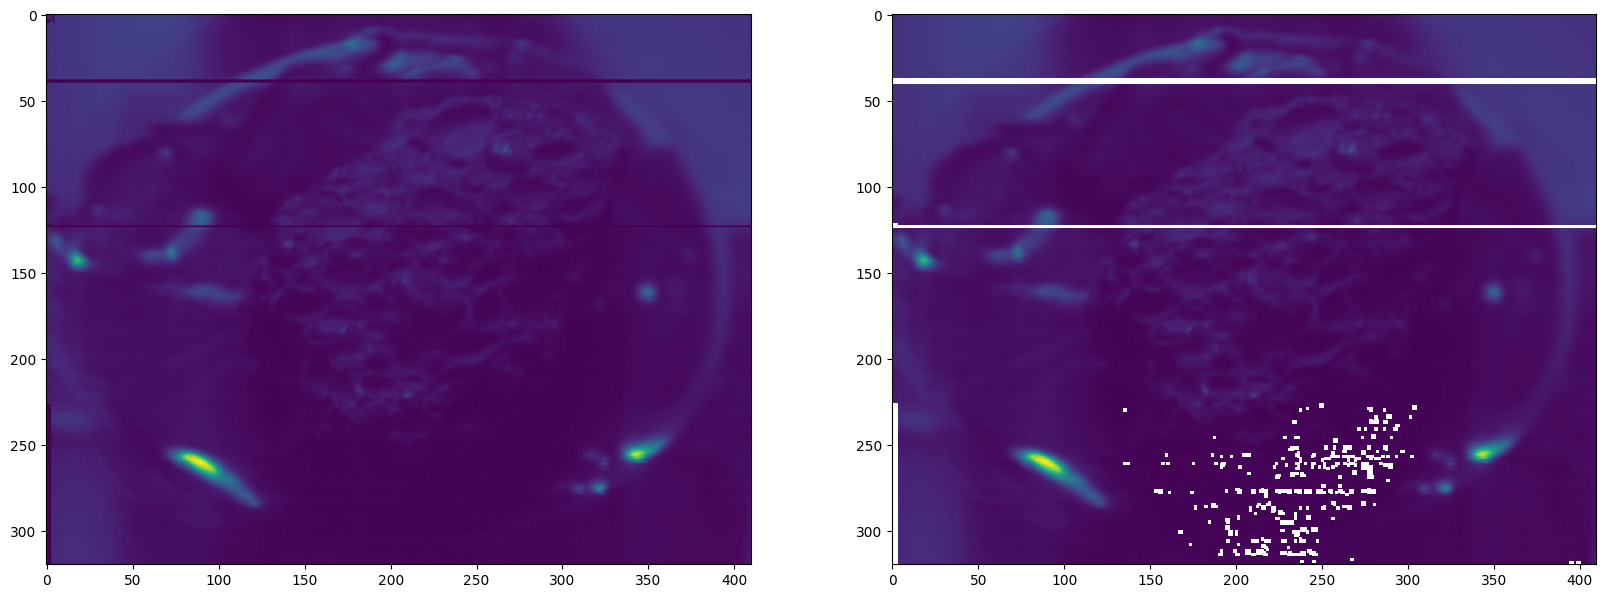

In [7]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1,2,figsize=(20,10))
cmap = 'viridis'
ax[0].imshow(reconstructed_image,cmap=cmap)
ax[1].imshow(hdr_data[ch,:,:],cmap=cmap)
plt.show()

100%|██████████| 559863/559863 [00:01<00:00, 360663.43it/s]

(320, 410, 256)


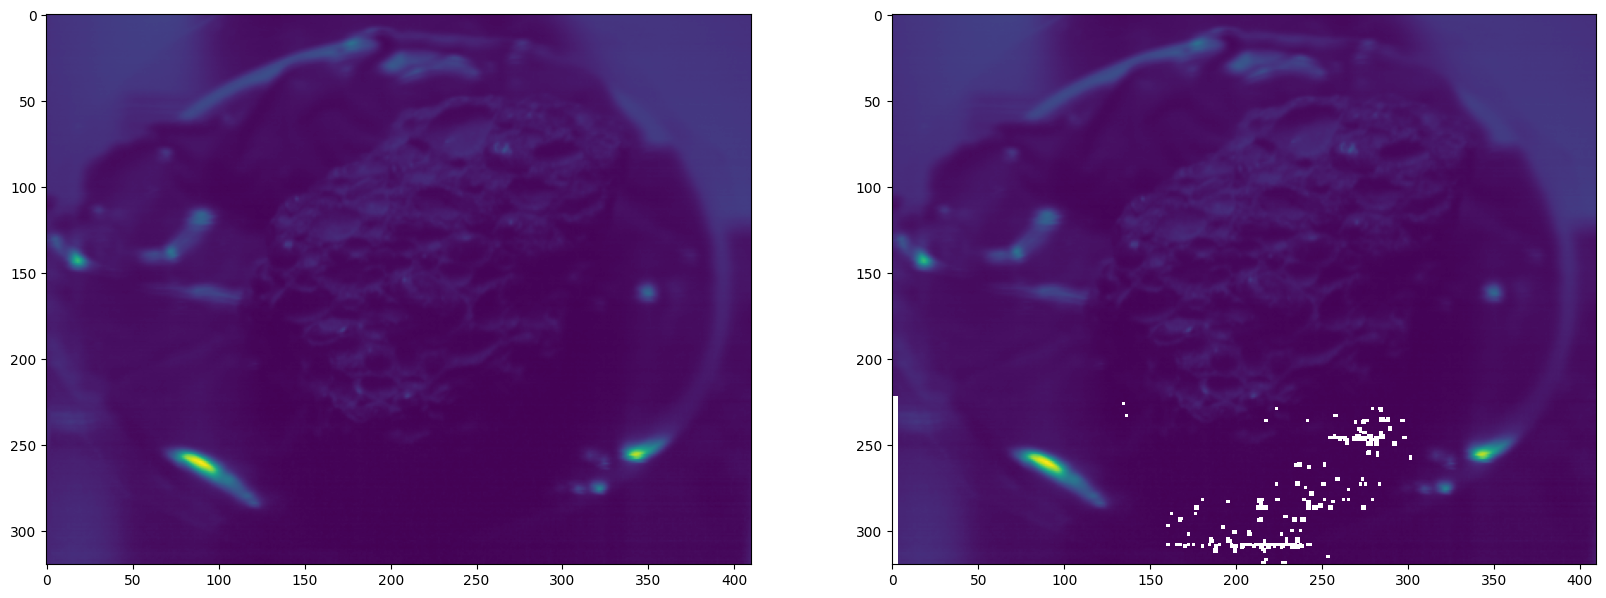

In [ ]:

                
def fill_nan(patch,coordinates): # coordinats = (x,y,c)
    data = patch.copy()
    (x,y,c) = coordinates
    if (c==0):
        if not np.isnan(data[x,y,c+1]):
            data[x,y,c] = data[x,y,c+1]
        else:
            data = spatial_avg(data,(x,y,c))
    elif (c==255):
        if not np.isnan(data[x,y,c-1]):
            data[x,y,c] = data[x,y,c-1]
        else:
            data = spatial_avg(data,(x,y,c))
    else:
        if (not np.isnan(data[x,y,c+1])) and (not np.isnan(data[x,y,c-1])):
            data[x,y,c] = np.mean([data[x,y,c+1],data[x,y,c-1]])
        elif not np.isnan(data[x,y,c-1]):
            data[x,y,c] = data[x,y,c-1]
        elif not np.isnan(data[x,y,c+1]):
            data[x,y,c] = data[x,y,c+1]
        else:
            data = spatial_avg(data,(x,y,c))
    return data


In [32]:
# import shutil
# shutil.rmtree("E:\\Patches_Data\\")